In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

AMS 241, Problem Set 1, Problem 2

Zachary Jennings

Consider a DP prior $DP(\alpha,G_0)$ with $G_0 = N(0,1)$. 

In [385]:
class DP(object):
    '''
    Class to hold a DP prior.
    '''
    def __init__(self,g='foo',func_type='normal',**kwargs):
        '''
        Parameters:
        g: scipy.stats object. if not specified, function type is used
        alpha: precision parameter for dirichlet distribution
        '''            
        #check if custom function is passed, else use that specified
        if g == 'foo':
            if func_type == 'normal':
                self.g = stats.norm(**kwargs)
            elif func_type == 'uniform':
                self.g = stats.uniform(**kwargs)
            else:
                print 'Error: No valid function supplied or specified.'
                
        else:
            self.g = g
        
        
    def DrawCDFFerg(self,alpha=1.,grid=np.linspace(-4,4,100),n_cdf=1):
        '''
        Draw a CDF realization, using method of Fergueson 1973
        Parameters:
            grid: n x 1 space of values on which to draw Dirichlet values
            
            n_cdf: int
                number of CDFs to generate
        
        '''
        g_draws = self.g.cdf(grid)
        g_draws = np.insert(g_draws,grid.size,1.)
        g_diff = g_draws[1:] - g_draws[:-1]
        
        cdf_arr = []
        for i in range(n_cdf):
            p = stats.dirichlet.rvs(alpha*g_diff)
            p = np.insert(p,0.,0.)
            p = np.cumsum(p)
            cdf_arr.append(CDF(grid,p))
        
        return cdf_arr
    
    def DrawCDFStick(self,alpha=1.,n_cdf=1,e=0.001,n_max=1e4):
        '''
        Draw a CDF realization, using stick-breaking constructive method.
        Stop occurs using error-tolerance stop.
        '''
        #generate lists to hold the relevant values
        cdf_arr = []
        beta = stats.beta(1,alpha)
        
        #start the primary cdf generation loop
        for i in range(n_cdf):
            x = []
            p = []
            z = []
            z.append(beta.rvs())
            x.append(self.g.rvs())
            p.append(z[0])
            
            #iterate for stick breaking process with appropriate exit conditions
            while (alpha/(1.+alpha))**len(x) > e and len(x) < n_max:
                x.append(self.g.rvs())
                this_z = beta.rvs()
                this_w = np.prod(1.-np.array(z))
                p.append(this_w * this_z)
                
                z.append(this_z)
    
                if len(x) >= n_max:
                    print 'Max iterations exceeded, exiting generation loop'

                
            self.x = x
            self.z = z
            self.p = p
                
            sort_x = np.argsort(x)
            x = np.array(x)[sort_x]
            p = np.insert(p,0.,0.)
            p = np.cumsum(np.array(p)[sort_x])
            cdf_arr.append(CDF(x,p))
            
            
        return cdf_arr
    
    def MDPGamma(self,grid=np.linspace(-4,4,100),a=1.,b=1.,n_cdf=1):
        gamma = stats.gamma(a,b)
        cdf_arr = []

        for i in np.arange(n_cdf):
            alpha = gamma.rvs()
            draw_cdf = self.DrawCDFFerg(alpha=alpha,n_cdf=1,grid=grid)[0]
            cdf_arr.append(draw_cdf)
        
        return cdf_arr
    
    def PlotCDFs(self,cdf_arr,grid=np.linspace(-4,4,100),**kwargs):
        '''
        Plot a list of CDFs for values of grid
        Parameters:
            cdf_arr: list of CDF objects
            grid: x-grid for plotting
        '''
        fig,ax = plt.subplots()
        ax.set_ylim(0.,1.)
        
        for i in cdf_arr:
            p = map(i.GetProb,grid)
            ax.plot(grid,p,**kwargs)
        
        
class CDF(object):
    '''
    Class to hold a single 1D discrete, DP-generated CDF
    '''
    def __init__(self,x,p):
        '''
        Parameters:
        x: n x 1 array where 
        p: (n+1) x 1 array which holds P(X < x)
        '''
        self.x = np.array(x)
        self.cdf = np.array(p)
        #ins_cdf = np.insert(self.cdf,0,0.)
        self.pdf = self.cdf[1:] - self.cdf[:-1]
        
    def GetProb(self,check_x):
        '''
        Return P(x < check_x)
        '''
        #if check_x is below the region where the CDF is defined, make sure to return 0.     
        if np.all(check_x < self.x):
            return 0.0
                
        if np.all(check_x > self.x):
            return 1.0
        
        diff = check_x - self.x
        mask = diff < 0.
        
        masked_diff = np.ma.masked_array(diff, mask)
        return self.cdf[masked_diff.argmin()+1]
    
    def GetMean(self):
        '''
        Return the mean (weighted average) of the distributuion
        '''
        return np.sum(self.pdf * self.x)
    
    def GetSD(self):
        '''|
        Return the weighted variance of the distribution
        '''
        return np.sum(self.pdf * self.x**2) - self.GetMean()**2
        
        #return np.sum(self.pdf * (self.x - self.GetMean())**2)/((self.pdf.size - 1.)/(self.pdf.size)*np.sum(self.pdf))


In [392]:
dp = DP()
cdf_arr = dp.MDPGamma(n_cdf=30,a=1,b=1)
means = []
stddevs = []
for i in cdf_arr:
    means.append(i.GetMean())
    stddevs.append(i.GetSD())
print np.median(means)

0.14755061033


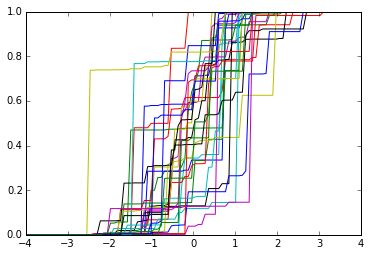

In [393]:
dp.PlotCDFs(cdf_arr)

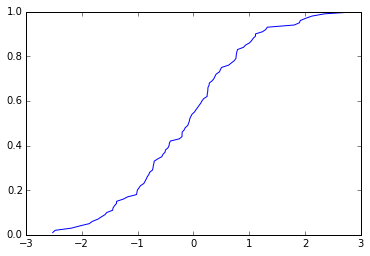

In [262]:
plt.plot(cdf_arr[1].x,cdf_arr[1].cdf[1:])

In [353]:
cdf_arr = []
grid = np.linspace(-4,4,100)
med_arr = []
stddev_arr = []
for j in range(50):
    means = []
    stddev = []
    cdf_arr = []
    
    for i in range(1000):
        x = stats.norm.rvs(size=100)
        x = np.sort(x)
        y = np.linspace(0.,1.,101)
        cdf_arr.append(CDF(x,y))
        means.append(cdf_arr[i].GetMean())
        stddev.append(cdf_arr[i].GetSD())
        
    med_arr.append(np.median(means))
    stddev_arr.append(np.median(stddev))


In [83]:
foo = np.insert(cdf_arr[0].cdf,cdf_arr[0].cdf.size,1.)
print foo[1:] - foo[:-1]
print cdf_arr[0].cdf[:] - np.insert(cdf_arr[0].cdf,cdf_arr[0].cdf.size,1.)[:-1]

[  3.25578215e-18   2.82835379e-24   4.20527855e-07   4.88049796e-19
   6.46182301e-12   2.14117372e-07   8.94515352e-06   2.54985947e-04
   3.05321663e-04   5.59104615e-10   2.16793406e-05   4.60126088e-04
   5.73005726e-04   9.42933946e-05   3.28489555e-04   1.35049258e-04
   1.34988171e-03   3.00147177e-03   2.27591395e-03   1.30576421e-03
   3.38103647e-03   1.03868344e-03   2.68944825e-03   6.54741632e-03
   1.05916909e-02   2.76308748e-03   3.68274942e-03   6.57318133e-03
   1.01000596e-02   1.36014984e-02   4.52641529e-03   1.46116745e-02
   1.68564196e-02   9.20372427e-03   1.86540853e-02   1.61757737e-02
   1.82539802e-02   2.35110357e-02   2.76798819e-02   2.52390408e-02
   2.23895349e-02   2.28074022e-02   3.72845177e-02   3.00035850e-02
   3.21814549e-02   2.48242458e-02   3.43607473e-02   2.51439391e-02
   3.36968759e-02   3.47058469e-02   3.80207036e-02   2.75784732e-02
   2.91625307e-02   2.37799528e-02   2.35281060e-02   2.92920591e-02
   2.01382774e-02   3.15985896e-02

In [73]:
pdf = foo[1:] - foo[:-1]
np.sum(pdf * cdf_arr[0].x)

-0.13103727050432837

In [52]:
grid = np.linspace(-4,4,100)
g_draws = stats.norm.cdf(grid)
g_draws = np.insert(g_draws,grid.size,1.)
g_diff = g_draws[1:] - g_draws[:-1]
print g_diff.size

100


In [238]:
class EmpericalDistribution(stats.rv_continuous):
    
    def SetParameters(self,x,p,d_type='cdf'):
        p = np.array(p)[np.argsort(x)]
        self.x = np.array(x)[np.argsort(x)]
        
        if d_type == 'pdf':
            self.p = np.cumsum(p)
        else:
            self.p = p
        
        
    
    def _cdf(self,check_x):
        if np.all(check_x < self.x):
            return 0.0
        
        if np.all(check_x > self.x):
            return 1.0
        
        diff = check_x - self.x
        mask = diff < 0.
        
        masked_diff = np.ma.masked_array(diff, mask)
        return self.p[masked_diff.argmin()]

In [109]:
dp.p

[0.2183850826968432,
 0.78131196631067978,
 0.19299689233354664,
 0.010697301704192152,
 0.0037585826834016633,
 0.0094372690352094359,
 0.001789514262302305,
 6.777355704258306e-06,
 4.3939264958602757e-07,
 8.9026124561464268e-07]

In [171]:
cdf = CDF(np.array([0,1,2,3]),np.array([0.1,0.3,0.95,1.0]))

In [154]:
diff = -0.5 - np.array([0,1,2,3])
print diff
mask = diff < 0
print mask
masked_diff = np.ma.masked_array(diff,mask)
print masked_diff
print masked_diff.argmin()

[-0.5 -1.5 -2.5 -3.5]
[ True  True  True  True]
[-- -- -- --]
0


In [64]:
g_grid = rv.cdf(foo)
g_diff = g_grid[1:] - g_grid[:-1]
p = stats.dirichlet.rvs(g_diff * 0.1)

In [32]:
len(cdf_arr[0].x)
(10./(10.+1))**10000

0.0

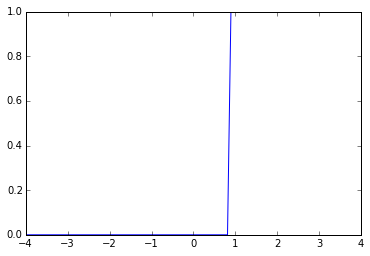

In [67]:
plt.plot(np.linspace(-4,4,99),sum)

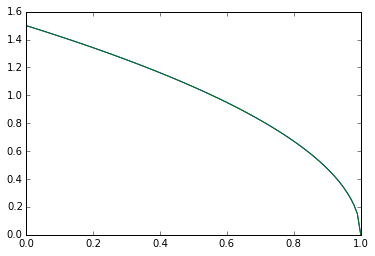

In [81]:
a = 1
b = 1.5
foo = np.linspace(0,1,100)
beta = stats.beta(a,b)
plt.plot(foo,beta.pdf(foo))
plt.plot(foo,stats.beta.pdf(foo,a,b))